In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from tqdm import tqdm
from gensim.models import FastText
from scipy.special import softmax
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
cbow_model = FastText.load("models/fasttext_cbow")
skip_model = FastText.load("models/fasttext_sg")

In [14]:
sample = pd.read_csv("data/pt_sample_clean_articles.csv")

In [15]:
sample["sentence_tokens"] = sample.text_clean.apply(lambda text: text.split(' '))
sample["sentence_len"] = sample.sentence_tokens.apply(lambda tokens: len(tokens))
sample = sample[sample.sentence_len > 14]

<AxesSubplot:>

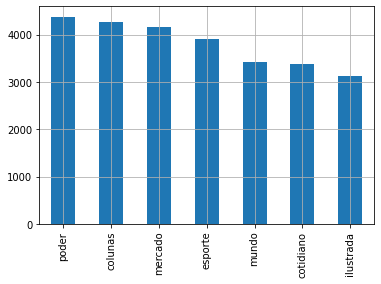

In [16]:
sample.category.value_counts().plot(kind='bar', grid=True)

In [17]:
sample.groupby("category").agg({"sentence_len": ["max", "min", "mean", "std"]})

sentence_len                            
                   max min        mean         std
category                                          
colunas           5559  15  284.957133  156.425930
cotidiano         1710  16  252.123818  158.454574
esporte           2324  20  212.740087  141.340121
ilustrada         2237  16  244.453350  171.822922
mercado           4879  16  277.827520  183.178904
mundo             2269  19  272.711735  175.751087
poder             2580  19  279.431834  177.485884

In [18]:
tf = TfidfVectorizer(min_df=3)
tf.fit_transform(sample.text_clean)

<26634x67449 sparse matrix of type '<class 'numpy.float64'>'
	with 5061538 stored elements in Compressed Sparse Row format>

In [21]:
tfidf_matrix = [ np.mean(np.array([ tf.vocabulary_[token] for token in sent if token in tf.vocabulary_ ]), axis=0) for sent in sample.sentence_tokens ]

In [68]:
def get_positional_embs(n_words=5559, dim=200):

    return np.vstack([ positional_vector(i, dim=dim) for i in range(n_words) ])

def positional_vector(pos, dim=100, denom=10000):

    pos_values = []
    for i in range(dim):
        pw = 2 * i
        if i % 2 == 0:
            res = np.sin(pos / np.power(denom, pw/dim))
        else:
            res = np.cos(pos / np.power(denom, pw/dim))
        pos_values.append(res)
    return np.array(pos_values)

def tokens_to_embs(sent_tokens, cbow, skip, option=1, pos_embs=None, idf=None):

    if option not in [1,2,3]:
        option = 2

    # Cbow somente
    if option == 1:
        words_vec = np.vstack([ cbow.wv[token] for token in sent_tokens if token in cbow.wv ])
    # Skip Gram
    elif option == 2:
        words_vec = np.vstack([ cbow.wv[token] for token in sent_tokens if token in cbow.wv ])
    # Skip e Cbow Combinados.
    elif option == 3:
        words_vec = np.vstack([ np.hstack([cbow.wv[token], skip.wv[token]]) for token in sent_tokens if token in cbow.wv ])
    
    if pos_embs is not None:
        words_vec += pos_embs[:words_vec.shape[0], :words_vec.shape[1]]
        return words_vec
    if idf is not None:
        return (words_vec.T * idf).T
    return words_vec

def get_raw_embs(sentences_tokes, cbow, skip, option=1, pos_embs=None, tfidf_matrix=None):

    if tfidf_matrix is None:
        return np.vstack([ np.mean(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs), axis=0) for sent_tokens in tqdm(sentences_tokes) ])
    else:
        return np.vstack([ np.mean(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs, idf=widf), axis=0) for sent_tokens, widf in tqdm(zip(sentences_tokes, tfidf_matrix)) ])

def attention_eval(embs, w_idf=None, norm="mean"):

    w = softmax(np.inner(embs, embs), axis=1)
    context_words = np.dot(w, embs)
    if norm == "mean":
        return np.mean(context_words, axis=0)
    else:
        return softmax(np.sum(context_words, axis=0), axis=0)

def attention(sentences_tokes, cbow, skip, option=1, norm="mean", pos_embs=None):

    return np.array([ attention_eval(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs)) for sent_tokens in tqdm(sentences_tokes) ])

In [10]:
pos_embs = get_positional_embs()

## Generating embeddings

In [69]:
dict_embs = {}
dict_embs["cbow"] = get_raw_embs(sample.sentence_tokens.values, cbow_model, skip_model, option=1, pos_embs=None, tfidf_matrix=tfidf_matrix)
dict_embs["cbow_postitional"] = get_raw_embs(sample.sentence_tokens.values, cbow_model, skip_model, option=1, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix)
dict_embs["skip"] = get_raw_embs(sample.sentence_tokens.values, cbow_model, skip_model, option=2, pos_embs=None, tfidf_matrix=tfidf_matrix)
dict_embs["skip_postitional"] = get_raw_embs(sample.sentence_tokens.values, cbow_model, skip_model, option=2, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix)
dict_embs["cbow_skip"] = get_raw_embs(sample.sentence_tokens.values, cbow_model, skip_model, option=3, pos_embs=None, tfidf_matrix=tfidf_matrix)
dict_embs["cbow_skip_postitional"] = get_raw_embs(sample.sentence_tokens.values, cbow_model, skip_model, option=3, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix)

26634it [00:30, 872.24it/s]
26634it [00:32, 823.58it/s]
26634it [00:30, 885.66it/s]
26634it [00:32, 825.76it/s]
26634it [01:19, 333.22it/s]
26634it [01:22, 321.96it/s]


## Setting up classifiers

In [70]:
dict_clfs = {}
dict_clfs["LogisticRegression"] = LogisticRegression(max_iter=5000, n_jobs=10)

# Cross-Validation

In [71]:
dict_scores = {}
le = preprocessing.LabelEncoder()
le.fit(sample.category.values)
y_true = le.transform(sample.category.values)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [72]:
for key_emb in tqdm(dict_embs):
    print(f"Embedding: {key_emb}")
    dict_scores[key_emb] = {}
    # Para cada fold.
    for train_idx, test_idx in tqdm(kf.split(dict_embs[key_emb], y_true)):
        # Para cada classificador.
        for key_clf in dict_clfs:
            print(f"\t\tClassifier: {key_clf}")
            dict_clfs[key_clf].fit(dict_embs[key_emb][train_idx], y_true[train_idx])
            y_pred = dict_clfs[key_clf].predict(dict_embs[key_emb][test_idx])
            if key_clf not in dict_scores[key_emb]:
                dict_scores[key_emb][key_clf] = {}
            # Calculando métricas.
            if "micro" not in dict_scores[key_emb][key_clf]:
                dict_scores[key_emb][key_clf]["micro"] = []
            dict_scores[key_emb][key_clf]["micro"].append(f1_score(y_true[test_idx], y_pred, average="micro"))
            if "macro" not in dict_scores[key_emb][key_clf]:
                dict_scores[key_emb][key_clf]["macro"] = []
            dict_scores[key_emb][key_clf]["macro"].append(f1_score(y_true[test_idx], y_pred, average="macro"))
            if "precision" not in dict_scores[key_emb][key_clf]:
                dict_scores[key_emb][key_clf]["precision"] = []
            dict_scores[key_emb][key_clf]["precision"].append(precision_score(y_true[test_idx], y_pred, average="macro"))
            if "recall" not in dict_scores[key_emb][key_clf]:
                dict_scores[key_emb][key_clf]["recall"] = []
            dict_scores[key_emb][key_clf]["recall"].append(recall_score(y_true[test_idx], y_pred, average="macro"))

  0%|          | 0/6 [00:00<?, ?it/s]

Embedding: cbow


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


5it [00:52, 10.46s/it]
 17%|█▋        | 1/6 [00:52<04:21, 52.32s/it]

Embedding: cbow_postitional


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


5it [01:42, 20.60s/it]
 33%|███▎      | 2/6 [02:35<05:28, 82.13s/it]

Embedding: skip


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


5it [00:49,  9.93s/it]
 50%|█████     | 3/6 [03:24<03:21, 67.30s/it]

Embedding: skip_postitional


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


5it [01:40, 20.08s/it]
 67%|██████▋   | 4/6 [05:05<02:40, 80.36s/it]

Embedding: cbow_skip


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


5it [10:55, 131.11s/it]
 83%|████████▎ | 5/6 [16:00<04:47, 287.77s/it]

Embedding: cbow_skip_postitional


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


		Classifier: LogisticRegression


In [ ]:
for emb in dict_scores:
    for clf in dict_scores[emb]:
        print(emb, np.mean(dict_scores[emb][clf]["macro"]), np.std(dict_scores[emb][clf]["macro"]))

cbow 0.8324251153959921 0.0023846018934665547
cbow_postitional 0.831711750812502 0.0025079873158895603
skip 0.8324251153959921 0.0023846018934665547
skip_postitional 0.831711750812502 0.0025079873158895603
cbow_skip 0.8392559227186147 0.002614862039181853
cbow_skip_postitional 0.8440224629809521 0.004451939391685543


In [ ]:
with open("outputs/scores_idf.json","w") as fd:
    json.dump(dict_scores, fd)